# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [ ]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [165]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [166]:
print(f"Torch: {torch.__version__}")

Torch: 1.12.1+cpu


In [169]:
# Training settings
batch_size = 8
epochs = 20
lr = 1e-2
gamma = 0.7
seed = 42

In [170]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [171]:
device = 'cpu'

## Load Data

In [173]:
os.makedirs('data', exist_ok=True)

In [174]:
import os 
os.getcwd() # 查看当前路径

'e:\\Python_Code\\ImpresClassifier'

In [176]:
# zipfile.ZipFile('./data/train/train.zip')
data_list = glob.glob(os.path.join('E:\Python_Code\ImpresClassifier\data\*','*.jpg'))

print(len(data_list))

1000


In [177]:
import random
len_data = 1000
data_list = random.sample(data_list,len_data)
len_train = 600
len_test = len_data - len_train
train_list = data_list[:len_train]
test_list = data_list[len_train:]

In [178]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")
print(train_list)
print(test_list)

Train Data: 600
Test Data: 400
['E:\\Python_Code\\ImpresClassifier\\data\\Other\\aug-195-12.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Angry\\aug-133-76.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Angry\\32.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Sad\\010.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\happy\\039.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\happy\\001.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Angry\\aug-8-12.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Angry\\aug-159-16.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Sad\\005.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Angry\\aug-124-63.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Other\\aug-47-02.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Sad\\009.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Sad\\aug-20-026.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Other\\aug-108-23.jpg', 'E:\\Python_Code\\ImpresClassifier\\data\\Angry\\aug-110-48.jpg', 'E:\\Python_Code\\ImpresClassifi

In [179]:
labels = [path.split('\\')[-2].split('.')[0] for path in train_list]
print(labels)
test_labels = [path.split('\\')[-2].split('.')[0] for path in test_list]
print(test_labels)

['Other', 'Angry', 'Angry', 'Sad', 'happy', 'happy', 'Angry', 'Angry', 'Sad', 'Angry', 'Other', 'Sad', 'Sad', 'Other', 'Angry', 'Other', 'happy', 'Angry', 'Angry', 'Angry', 'Angry', 'Angry', 'Other', 'Other', 'Angry', 'Other', 'Angry', 'Other', 'Other', 'Other', 'Sad', 'happy', 'Angry', 'happy', 'Other', 'happy', 'Sad', 'Sad', 'Angry', 'Sad', 'Sad', 'Angry', 'Other', 'Sad', 'happy', 'Sad', 'Angry', 'Angry', 'Sad', 'happy', 'Sad', 'Angry', 'happy', 'Angry', 'happy', 'Sad', 'happy', 'Other', 'happy', 'Sad', 'Angry', 'Other', 'happy', 'Other', 'Angry', 'happy', 'Angry', 'Other', 'happy', 'Sad', 'Other', 'Other', 'Sad', 'Sad', 'happy', 'Other', 'Angry', 'Other', 'Angry', 'Angry', 'Other', 'Angry', 'Sad', 'happy', 'Angry', 'Sad', 'Sad', 'Sad', 'Angry', 'Sad', 'Sad', 'happy', 'Other', 'Sad', 'happy', 'Angry', 'happy', 'happy', 'Angry', 'Other', 'happy', 'Sad', 'Other', 'Other', 'Angry', 'Other', 'Sad', 'Angry', 'Other', 'Other', 'Sad', 'Angry', 'happy', 'happy', 'happy', 'Other', 'Other', 'O

## Random Plots

Exception ignored in: <function tqdm.__del__ at 0x000002280DB8B670>
Traceback (most recent call last):
  File "d:\miniconda3\envs\pytorch\lib\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "d:\miniconda3\envs\pytorch\lib\site-packages\tqdm\notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


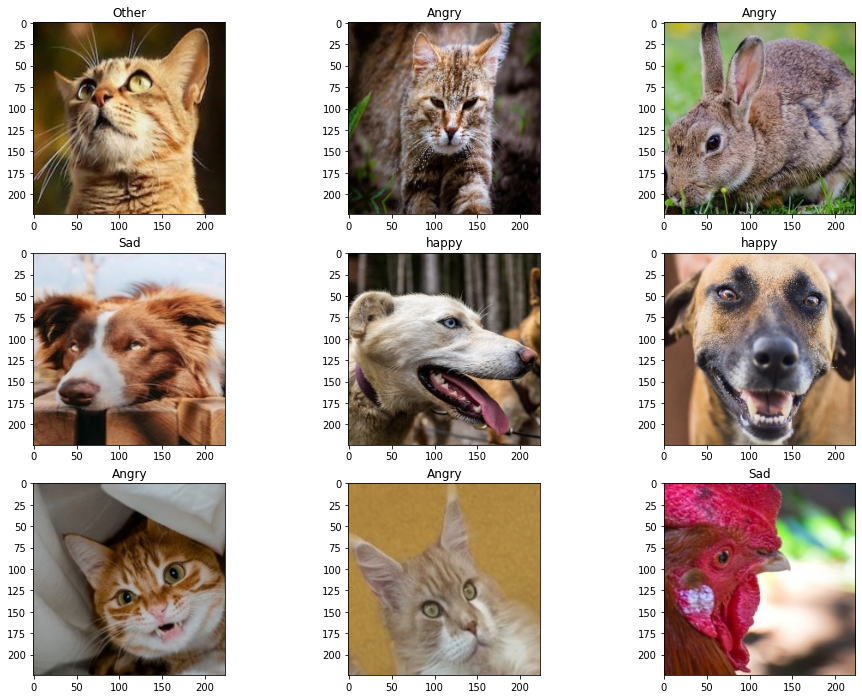

In [180]:
random_idx = np.random.randint(1, len(train_list), size=9)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [181]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size =0.2,
                                          stratify=labels,
                                          random_state=seed)

In [182]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 480
Validation Data: 120
Test Data: 400


## Image Augmentation

In [183]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [185]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("\\")[-2].split(".")[0]
        tmp = 0
        if label == 'Angry':
            tmp = 0
        elif label == 'Sad':
            tmp = 1
        elif label == 'happy':
            tmp = 2
        else:
            tmp = 3
        label =tmp# torch.tensor(tmp,dtype=float)
        # label = torch.tensor(tmp,dtype=float)
        return img_transformed, label


In [186]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [187]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [188]:
print(len(train_data), len(train_loader))

480 60


In [189]:
print(len(valid_data), len(valid_loader))

120 15


## Efficient Attention

### Linformer

In [190]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [191]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=4,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [193]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [194]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #acc = (output.max(1)[1] == label).float().mean()
        acc = (output.argmax(dim=1) == label).float().mean()

        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch: {epoch+1} Train Loss: {epoch_loss:.4f} Train Acc: {epoch_accuracy:.4f} Val_Loss: {epoch_val_loss:.4f} Val_Acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch: 1 Train Loss: 1.6682 Train Acc: 0.2708 Val_Loss: 1.4372 Val_Acc: 0.2500

Epoch: 2 Train Loss: 1.4455 Train Acc: 0.2667 Val_Loss: 1.4656 Val_Acc: 0.2333

Epoch: 3 Train Loss: 1.3957 Train Acc: 0.3062 Val_Loss: 1.4124 Val_Acc: 0.2333

Epoch: 4 Train Loss: 1.4068 Train Acc: 0.2625 Val_Loss: 1.4334 Val_Acc: 0.2583

Epoch: 5 Train Loss: 1.3978 Train Acc: 0.2479 Val_Loss: 1.3974 Val_Acc: 0.2500

Epoch: 6 Train Loss: 1.3894 Train Acc: 0.2562 Val_Loss: 1.3996 Val_Acc: 0.2583

Epoch: 7 Train Loss: 1.3930 Train Acc: 0.2458 Val_Loss: 1.3859 Val_Acc: 0.2500

Epoch: 8 Train Loss: 1.3885 Train Acc: 0.2625 Val_Loss: 1.3977 Val_Acc: 0.2583

Epoch: 9 Train Loss: 1.3930 Train Acc: 0.2500 Val_Loss: 1.3865 Val_Acc: 0.2500

Epoch: 10 Train Loss: 1.3893 Train Acc: 0.2146 Val_Loss: 1.3866 Val_Acc: 0.2500

Epoch: 11 Train Loss: 1.3876 Train Acc: 0.2562 Val_Loss: 1.3861 Val_Acc: 0.2583

Epoch: 12 Train Loss: 1.3909 Train Acc: 0.2479 Val_Loss: 1.3936 Val_Acc: 0.2333

Epoch: 13 Train Loss: 1.3949 Train Ac

In [162]:
# 保存
torch.save(model, './result/model.pkl')
# 加载
model = torch.load('./result/model.pkl')


In [163]:
def test():
    with torch.no_grad():
        test_accuracy = 0
        test_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            test_output = model(data)
            test_loss = criterion(test_output, label)

            acc = (test_output.argmax(dim=1) == label).float().mean()
            test_accuracy += acc / len(test_loader)
            test_loss += test_loss / len(test_loader)
            print(f"Test Acc : {test_accuracy:.4f}, Test_Loss : {test_loss:.4f}\n")

In [164]:
test()

Test Acc : 0.0040, Test_Loss : 1.4224

Test Acc : 0.0099, Test_Loss : 1.3913

Test Acc : 0.0119, Test_Loss : 1.3745

Test Acc : 0.0139, Test_Loss : 1.4127

Test Acc : 0.0139, Test_Loss : 1.5110

Test Acc : 0.0179, Test_Loss : 1.4388

Test Acc : 0.0198, Test_Loss : 1.4810

Test Acc : 0.0258, Test_Loss : 1.4037

Test Acc : 0.0337, Test_Loss : 1.3375

Test Acc : 0.0397, Test_Loss : 1.4170

Test Acc : 0.0417, Test_Loss : 1.4478

Test Acc : 0.0476, Test_Loss : 1.3773

Test Acc : 0.0516, Test_Loss : 1.3935

Test Acc : 0.0556, Test_Loss : 1.4112

Test Acc : 0.0615, Test_Loss : 1.3972

Test Acc : 0.0675, Test_Loss : 1.3841

Test Acc : 0.0694, Test_Loss : 1.4575

Test Acc : 0.0774, Test_Loss : 1.2709

Test Acc : 0.0853, Test_Loss : 1.3517

Test Acc : 0.0873, Test_Loss : 1.4258

Test Acc : 0.0893, Test_Loss : 1.4751

Test Acc : 0.0952, Test_Loss : 1.3305

Test Acc : 0.1071, Test_Loss : 1.2746

Test Acc : 0.1111, Test_Loss : 1.3770

Test Acc : 0.1151, Test_Loss : 1.4060

Test Acc : 0.1210, Test_L

tensor(4.8828e-05, grad_fn=<AddBackward0>)